In [24]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn import set_config
set_config(transform_output="pandas")

df = pd.read_csv("CTG_clean.csv")
df = df[df["NSP"].notna()].copy()        # drop rows with missing target
df["NSP"] = df["NSP"].astype(int)        # ensure integer classes (e.g., 1/2/3)

y = df["NSP"].values
X = df.drop(columns=["NSP"])

In [25]:
class CTGEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, eps=1e-6):
        self.eps = eps
        self.eng_cols_ = None

    def fit(self, X, y=None):
        self.eng_cols_ = [
            "feat_tachycardia",
            "feat_bradycardia",
            "feat_variability_ratio",
            "feat_accel_decel_balance",
            "feat_decels_per_contraction",
            "feat_range",
            "feat_instability_proxy",
        ]
        return self

    def transform(self, X):
        X = X.copy()

        def g(*cands):
            for c in cands:
                if c in X.columns:
                    return c
            return None

        baseline = g("lb","baseline","mean_fhr","fhr_baseline","b")
        ac = g("ac","accelerations")
        dl = g("dl","decelerations_late","late_decelerations")
        ds = g("ds","decelerations_short","short_decelerations")
        dp = g("dp","decelerations_prolonged","prolonged_decelerations")
        uc = g("uc","uterine_contractions")
        mstv = g("mstv")
        altv = g("altv")
        mltv = g("mltv")
        width = g("width")
        vmin = g("min")
        vmax = g("max")

        if baseline is not None:
            X["feat_tachycardia"] = (X[baseline] > 160).astype(int)
            X["feat_bradycardia"] = (X[baseline] < 110).astype(int)

        if altv is not None and mstv is not None:
            X["feat_variability_ratio"] = X[altv] / (X[mstv] + self.eps)

        decel_cols = [c for c in [dl, ds, dp] if c is not None]
        if ac is not None and decel_cols:
            X["feat_accel_decel_balance"] = (X[ac] + 1.0) / (X[decel_cols].sum(axis=1) + 1.0)

        if uc is not None and decel_cols:
            X["feat_decels_per_contraction"] = X[decel_cols].sum(axis=1) / (X[uc] + 1.0)

        if vmax is not None and vmin is not None:
            X["feat_range"] = X[vmax] - X[vmin]

        if width is not None and mstv is not None:
            X["feat_instability_proxy"] = X[width] / (X[mstv] + 1.0)

        # Clean numeric infinities created by ratios
        num_cols = X.select_dtypes(include=[np.number]).columns
        X[num_cols] = X[num_cols].replace([np.inf, -np.inf], np.nan)

        # Only fill engineered columns here; the rest will be imputed downstream
        for c in self.eng_cols_:
            if c in X.columns and X[c].isna().any():
                X[c] = X[c].fillna(X[c].median())

        return X

In [26]:
numeric_selector = make_column_selector(dtype_include=np.number)

In [27]:
preprocess_trees = Pipeline([
    ("eng", CTGEngineer()),
    ("num", ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("impute", SimpleImputer(strategy="median")),
            ]), numeric_selector),
        ],
        remainder="drop"
    )),
])

preprocess_linear = Pipeline([
    ("eng", CTGEngineer()),
    ("num", ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("impute", SimpleImputer(strategy="median")),
                ("scale", StandardScaler()),
            ]), numeric_selector),
        ],
        remainder="drop"
    )),
])

pipe_lr  = Pipeline([("prep", preprocess_linear), ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))])
pipe_svm = Pipeline([("prep", preprocess_linear), ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced"))])
pipe_rf  = Pipeline([("prep", preprocess_trees),  ("clf", RandomForestClassifier(n_estimators=400, class_weight="balanced_subsample", random_state=42))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "macro_f1": make_scorer(f1_score, average="macro"),
    "bal_acc": make_scorer(balanced_accuracy_score)
}

In [28]:
def evaluate(pipe, X, y, name):
    res = cross_validate(pipe, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=False)
    print(f"{name:>12} | macro F1: {res['test_macro_f1'].mean():.3f} ± {res['test_macro_f1'].std():.3f}  | bal acc: {res['test_bal_acc'].mean():.3f}")
    return res

res_lr  = evaluate(pipe_lr,  X, y, "LogReg")
res_svm = evaluate(pipe_svm, X, y, "SVM RBF")
res_rf  = evaluate(pipe_rf,  X, y, "RandForest")

      LogReg | macro F1: 0.977 ± 0.009  | bal acc: 0.983
     SVM RBF | macro F1: 0.979 ± 0.012  | bal acc: 0.979
  RandForest | macro F1: 0.974 ± 0.013  | bal acc: 0.962


In [32]:
if __name__ == "__main__":
    best_pipe = pipe_lr
    X = X.drop(columns=["filename", "segfile"], errors="ignore")
    best_pipe.fit(X, y)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('eng', ...), ('num', ...)]"
,transform_input,None
,memory,None
,verbose,False
,eps,1e-06
,transformers,"[('num', ...)]"
,remainder,'drop'


In [33]:
if __name__ == "__main__":
    pipe_lr = Pipeline([
        ("prep", preprocess_linear),
        ("clf", LogisticRegression(
            max_iter=2000,
            class_weight="balanced",
            multi_class="multinomial",
            solver="lbfgs",
            n_jobs=-1
        ))
    ])
    
    X = X.drop(columns=["filename", "segfile"], errors="ignore")
    
    res_lr  = evaluate(pipe_lr, X, y, "LogReg")
    
    best_pipe = pipe_lr
    best_pipe.fit(X, y)

      LogReg | macro F1: 0.977 ± 0.009  | bal acc: 0.983


C:\Users\bang kai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('eng', ...), ('num', ...)]"
,transform_input,None
,memory,None
,verbose,False
,eps,1e-06
,transformers,"[('num', ...)]"
,remainder,'drop'


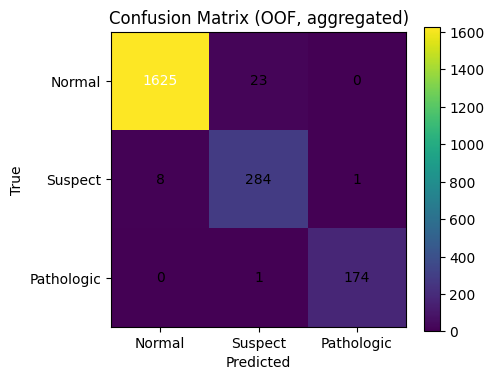

              precision    recall  f1-score   support

      Normal      0.995     0.986     0.991      1648
     Suspect      0.922     0.969     0.945       293
  Pathologic      0.994     0.994     0.994       175

    accuracy                          0.984      2116
   macro avg      0.970     0.983     0.977      2116
weighted avg      0.985     0.984     0.985      2116



In [35]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

if __name__ == "__main__":
    FIG_DIR = Path("reports/figures")
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    
    label_names = ["Normal","Suspect","Pathologic"]
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    classes = np.sort(np.unique(y))
    oof_prob = cross_val_predict(best_pipe, X, y, cv=skf, method="predict_proba", n_jobs=-1)
    oof_pred_idx = oof_prob.argmax(axis=1)
    oof_pred = classes[oof_pred_idx]   
    
    cm = confusion_matrix(y, oof_pred, labels=np.sort(np.unique(y)))
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix (OOF, aggregated)")
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, ["Normal","Suspect","Pathologic"], rotation=0)
    plt.yticks(ticks, ["Normal","Suspect","Pathologic"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center",
                     color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(FIG_DIR/"confusion_matrix_oof.png", dpi=160)
    plt.show()
    
    report_txt = classification_report(
        y, oof_pred,
        labels=classes,
        target_names=["Normal","Suspect","Pathologic"],
        digits=3
    )
    print(report_txt)
    with open(FIG_DIR/"classification_report_oof.txt","w") as f:
        f.write(report_txt)

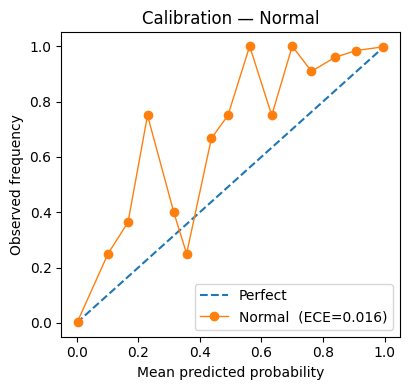

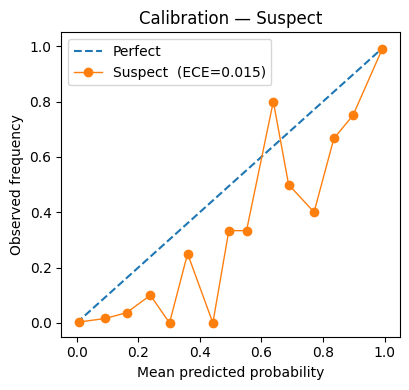

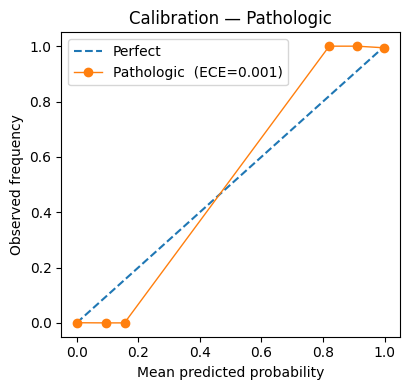

   class_id  class_name     ECE
0         1      Normal  0.0156
1         2     Suspect  0.0152
2         3  Pathologic  0.0013


In [37]:
from sklearn.calibration import calibration_curve

classes = np.sort(np.unique(y))
K = len(classes)

def expected_calibration_error(y_true_bin, y_prob, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = (bin_ids == b)
        if not np.any(mask):
            continue
        bin_conf = y_prob[mask].mean()
        bin_acc  = (y_true_bin[mask] == 1).mean()
        weight   = mask.mean()
        ece     += abs(bin_acc - bin_conf) * weight
    return ece

eces = []
rows = []

if __name__ == "__main__":
    for i, cls in enumerate(classes):
        y_bin = (y == cls).astype(int)
        p_cls = oof_prob[:, i]
    
        frac_pos, mean_pred = calibration_curve(
            y_bin, p_cls, n_bins=15, strategy="uniform"
        )
        ece_k = expected_calibration_error(y_bin, p_cls, n_bins=15)
        eces.append(ece_k)
        rows.append({"class_id": int(cls), "class_name": label_names[i], "ECE": round(ece_k, 4)})
    
        # plot
        plt.figure(figsize=(4.2, 4))
        plt.plot([0, 1], [0, 1], "--", label="Perfect")
        plt.plot(mean_pred, frac_pos, marker="o", linewidth=1,
                 label=f"{label_names[i]}  (ECE={ece_k:.03f})")
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Observed frequency")
        plt.title(f"Calibration — {label_names[i]}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"calibration_class{cls}.png", dpi=160)  # use true class id in filename
        plt.show()
    
    calib_df = pd.DataFrame(rows, columns=["class_id", "class_name", "ECE"])
    print(calib_df)
    calib_df.to_csv(FIG_DIR / "calibration_ece_oof.csv", index=False)

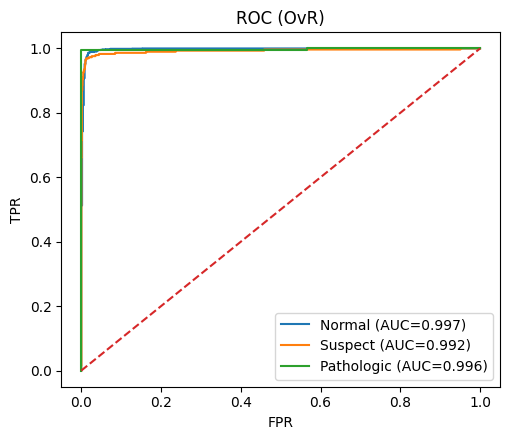

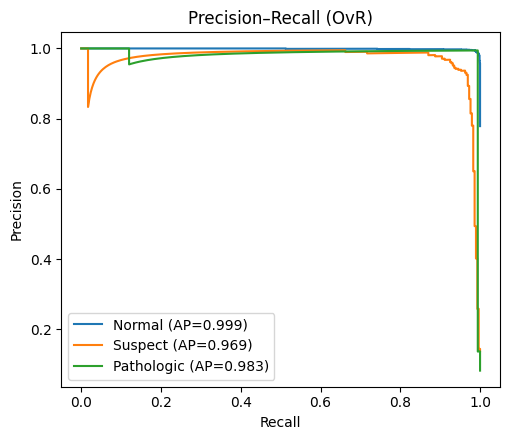

   class_id  class_name     AUC      AP
0         1      Normal  0.9971  0.9990
1         2     Suspect  0.9918  0.9693
2         3  Pathologic  0.9963  0.9833


In [38]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

if __name__ == "__main__":
    classes = np.sort(np.unique(y))
    K = len(classes)
    
    plt.figure(figsize=(5.2, 4.5))
    aucs = []
    for i, cls in enumerate(classes):
        y_bin = (y == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, oof_prob[:, i])  # column i ↔ classes[i]
        auc_i = auc(fpr, tpr)
        aucs.append(auc_i)
        plt.plot(fpr, tpr, label=f"{label_names[i]} (AUC={auc_i:.3f})")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (OvR)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / "roc_ovr.png", dpi=160)
    plt.show()
    
    plt.figure(figsize=(5.2, 4.5))
    aps = []
    for i, cls in enumerate(classes):
        y_bin = (y == cls).astype(int)
        prec, rec, _ = precision_recall_curve(y_bin, oof_prob[:, i])
        ap_i = average_precision_score(y_bin, oof_prob[:, i])
        aps.append(ap_i)
        plt.plot(rec, prec, label=f"{label_names[i]} (AP={ap_i:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (OvR)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / "pr_ovr.png", dpi=160)
    plt.show()
    
    per_class_df = pd.DataFrame({
        "class_id": classes.astype(int),
        "class_name": label_names,
        "AUC": np.round(aucs, 4),
        "AP": np.round(aps, 4),
    })
    print(per_class_df)
    per_class_df.to_csv(FIG_DIR / "ovr_auc_ap.csv", index=False)

In [39]:
if __name__ == "__main__":
    best_pipe.fit(X, y)
    
    pre = best_pipe.named_steps["prep"]
    ct  = pre.named_steps["num"]
    feat_names = ct.get_feature_names_out()
    
    # Clean names a bit
    feat_names = [name.split("__", 1)[-1] for name in feat_names]
    
    clf = best_pipe.named_steps["clf"]
    coef = clf.coef_
    classes = clf.classes_
    
    topk = 10
    coef_df = []
    for i, c in enumerate(classes):
        w = coef[i]
        idx_pos = np.argsort(w)[-topk:][::-1]
        idx_neg = np.argsort(w)[:topk]
        coef_df.append(pd.DataFrame({
            "class": [c]*topk,
            "direction": ["positive"]*topk,
            "feature": [feat_names[j] for j in idx_pos],
            "weight":  w[idx_pos]
        }))
        coef_df.append(pd.DataFrame({
            "class": [c]*topk,
            "direction": ["negative"]*topk,
            "feature": [feat_names[j] for j in idx_neg],
            "weight":  w[idx_neg]
        }))
    
    coef_df = pd.concat(coef_df, ignore_index=True)
    coef_df.head(20)

C:\Users\bang kai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,class,direction,feature,weight
0,1,positive,ad,1.677253
1,1,positive,de,1.525370
2,1,positive,ac,1.016379
3,1,positive,dl,0.947613
4,1,positive,feat_accel_decel_balance,0.819848
5,1,positive,b,0.779957
6,1,positive,mode,0.623932
7,1,positive,mltv,0.393598
8,1,positive,d,0.383227
9,1,positive,c,0.359833


     feature  importance       std
0      class    0.246961  0.006379
1         ld    0.178990  0.005116
2         fs    0.118504  0.004208
3       mean    0.101302  0.008164
4         de    0.094366  0.002291
5         ad    0.081996  0.003446
6         ac    0.056472  0.005541
7         dp    0.040722  0.003665
8         dl    0.018646  0.002545
9          b    0.017088  0.003050
10        uc    0.011139  0.002360
11  variance    0.009859  0.002668
12     width    0.007122  0.003006
13    median    0.005460  0.002048
14      mode    0.005088  0.002500
15      astv    0.004445  0.001577
16         d    0.003895  0.001310
17      mstv    0.003592  0.001443
18         c    0.002278  0.001192
19         e    0.002215  0.001542


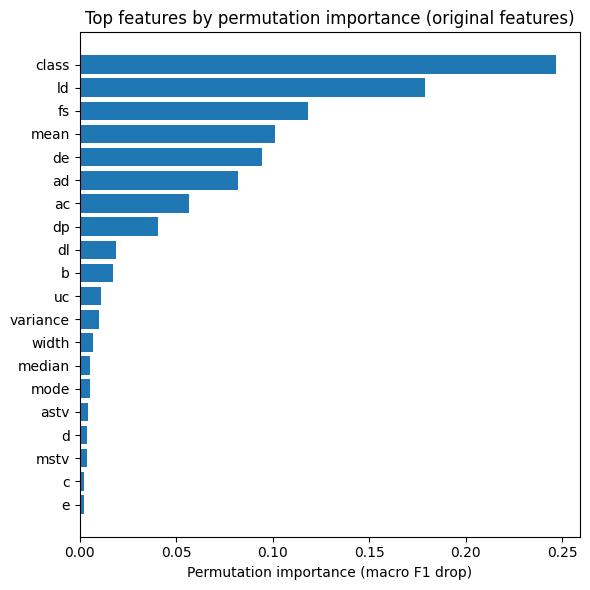

In [42]:
from sklearn.inspection import permutation_importance
if __name__ == "__main__":
    orig_feat_names = list(X.columns)
    
    pi = pd.DataFrame({
        "feature": orig_feat_names,
        "importance": r.importances_mean,
        "std": r.importances_std
    }).sort_values("importance", ascending=False, ignore_index=True)
    
    print(pi.head(20))
    
    plt.figure(figsize=(6,6))
    plt.barh(pi.head(20)["feature"][::-1], pi.head(20)["importance"][::-1])
    plt.xlabel("Permutation importance (macro F1 drop)")
    plt.title("Top features by permutation importance (original features)")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "permutation_importance_top20_original.png", dpi=160)
    plt.show()
    
    pi.to_csv(FIG_DIR / "permutation_importance_original.csv", index=False)

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

if __name__ == "__main__":
    search = RandomizedSearchCV(
        estimator=pipe_lr,
        param_distributions={
            "clf__C": loguniform(1e-3, 1e2)
        },
        n_iter=30,
        scoring="f1_macro",
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        random_state=42,
        refit=True
    )
    search.fit(X, y)
    
    print("Best macro F1:", search.best_score_)
    print("Best params:", search.best_params_)
    best_pipe = search.best_estimator_

Best macro F1: 0.9772534445322343
Best params: {'clf__C': np.float64(1.1462107403425035)}


C:\Users\bang kai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [46]:
from sklearn.calibration import CalibratedClassifierCV
import joblib

if __name__ == "__main__":
    calibrated_pipe = CalibratedClassifierCV(estimator=best_pipe, method="sigmoid", cv=5)
    calibrated_pipe.fit(X, y)
    
    joblib.dump(calibrated_pipe, "ctg_best_calibrated.joblib")
    print("Calibrated model saved successfully.")
    
    
    summary = {
        "model": ["Logistic Regression (multinomial, balanced)"],
        "cv_macro_f1_mean": [res_lr["test_macro_f1"].mean()],
        "cv_macro_f1_std":  [res_lr["test_macro_f1"].std()],
        "cv_balacc_mean":   [res_lr["test_bal_acc"].mean()],
        "cv_balacc_std":    [res_lr["test_bal_acc"].std()],
    }
    summary_df = pd.DataFrame(summary)
    summary_df.to_csv("reports/lr_cv_summary.csv", index=False)
    summary_df

C:\Users\bang kai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\bang kai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\bang kai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Calibrated model saved successfully.


C:\Users\bang kai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\bang kai\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,model,cv_macro_f1_mean,cv_macro_f1_std,cv_balacc_mean,cv_balacc_std
0,"Logistic Regression (multinomial, balanced)",0.97661,0.0087,0.983156,0.009371
